In [1]:
import numpy as np
import matplotlib.pyplot as plt
from simtk import unit

# Newtonian

To easily run tests with classical newtonian dynamics, the method `simulations.newtonian` provides a simple interface. Let's first of all see a simple example on how to use it:

In [2]:
from uibcdf_test_systems.simulation import newtonian
from uibcdf_test_systems import HarmonicWell

harmonic_well = HarmonicWell(n_particles=1, mass=10*unit.amu, k= 5*unit.kilocalories_per_mole/unit.nanometers**2)

initial_positions = np.zeros((1,3),dtype=float)*unit.nanometers
initial_velocities = np.zeros((1,3),dtype=float)*unit.nanometers/unit.picometers
initial_positions[0,0] = 0.5*unit.nanometers

time, position, velocity, kinetic_energy, potential_energy = newtonian(system=harmonic_well.system,
                                                                       initial_positions=initial_positions,
                                                                       initial_velocities=initial_velocities,
                                                                       integration_timestep=0.02*unit.picoseconds,
                                                                       saving_timestep=0.1*unit.picoseconds,
                                                                       total_time=50*unit.picoseconds)


Every method in the module `simulation` has at least five possible output arguments: `time`, `position`, `velocity`, `kinetic_energy` and `potential_energy`.

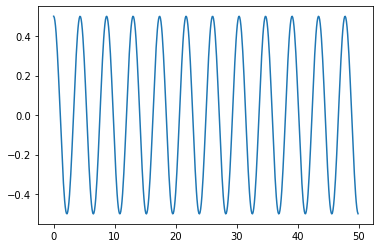

In [3]:
plt.plot(time, position[:,0,0])

The method can also be used to run classical newtonian dynamics with friction:

In [4]:
time, position, velocity, kinetic_energy, potential_energy = newtonian(system=harmonic_well.system,
                                                                       friction=0.5/unit.picoseconds,
                                                                       initial_positions=initial_positions,
                                                                       initial_velocities=initial_velocities,
                                                                       integration_timestep=0.02*unit.picoseconds,
                                                                       saving_timestep=0.1*unit.picoseconds,
                                                                       total_time=50*unit.picoseconds)


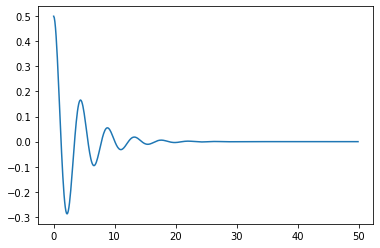

In [5]:
plt.plot(time, position[:,0,0])

At this moment the newtonian dynamics is performed as a Langevin dynamics at zero temperature. It can be done better with a newtonian integrator, but it is not implemented yet. Have a look to the source code of this method:

In [6]:
# %load ../../uibcdf_test_systems/simulation/newtonian.py

def newtonian(system, friction=None,
              initial_positions=None, initial_velocities=None, integration_timestep=None,
              saving_timestep=None, total_time=None, platform_name='CPU', verbose=True):

    """Newtonian classical dynamics of a molecular system with OpenMM.

    The trajectory of a newtonian classical dynamics of a molecular system is obtained together with the
    values of potential and kinetic energy. This method is nothing but a short cut to run quick
    molecular dynamics with the test systems of this library by means of OpenMM.

    Parameters
    ----------

    system: simtk.openmm.System
        Molecular system as a system class of OpenMM (see: link)
    friction: unit.Quantity
        Damping parameter of the Langevin dynamics (in units of 1/time).
    initial_positions: unit.Quantity
        Initial positions of the system as a numpy array with shape [n_particles, 3] and units of
        length. Where 'n_particles' is the number of particles of the system.
    initial_velocities: unit.Quantity
        Initial velocities of the system as a numpy array with shape [n_particles, 3] and units of
        length/time. Where 'n_particles' is the number of particles of the system.
    integration_timestep: unit.Quantity
        Time step used by the integrator of the equations of motion. The parameter needs to have
        units of time.
    saving_timestep: unit.Quantity
        Time step used to report the output trajectory. The parameter needs to have units of time.
    total_time: unit.Quantity
        Total runing time of the simulation. The parameter needs to have units of time.
    platform_name: str (default: 'CPU')
        Platform to run the dynamics: 'CPU', 'OPENCL' or 'CUDA' (according to those options to run
        OpenMM, see documentation),
    verbose: bool (default: True)
        Verbose switcher. The method will print out information if the value is True.

    Returns
    -------

    time: unit.Quantity
        Time as numpy array of shape [n_frames] with units of picoseconds.
    position: unit.Quantity
        Positions of the systems particles in every reported frame as numpy array of shape [n_frames, n_particles, 3] with units of nanometers.
    velocity: unit.Quantity
        Velocities of the systems particles in every reported frame as numpy array of shape
        [n_frames, n_particles, 3] with units of nanometers/picoseconds.
    kinetic_energy: unit.Quantity
        Kinetic energy of the system in every reported frame as numpy array of shape
        [n_frames] with units of kilocalories/mole.
    potential_energy: unit.Quantity
        Potential energy of the system in every reported frame as numpy array of shape
        [n_frames] with units of kilocalories/mole.

    Examples
    --------

    >>> from uibcdf_test_systems import DoubleWell
    >>> from uibcdf_test_systems.simulation import newtonian
    >>> from simtk import unit
    >>> double_well = DoubleWell(n_particles = 1, mass = 64 * unit.amu, Eo=4.0 * unit.kilocalories_per_mole, a=1.0 * unit.nanometers, b=0.0 * unit.kilocalories_per_mole))
    >>> initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
    >>> initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds
    >>> initial_positions[0,0] = 1.0 * unit.nanometers
    >>> time, position, velocity, kinetic_energy, potential_energy = langevin_NVT(double_well.system,
    >>>                                                                           friction = 0.1/unit.picoseconds,
    >>>                                                                           initial_positions = initial_positions,
    >>>                                                                           initial_velocities = initial_velocities,
    >>>                                                                           integration_timestep = 0.02 * unit.picoseconds,
    >>>                                                                           saving_timestep = 0.5 * unit.picoseconds,
    >>>                                                                           total_time = 100 * unit.picoseconds)

    Notes
    -----

    See the `corresponding documentation in the user guide regarding this method
        <../../simulations/newtonian.html>`_.

    Some simple examples on how this method is used can be found in the users guide sections
    corresponding to `the free particle <../../systems/free_particle.html>`_, `the harmonic
    well potential <../../systems/harmonic_well_potential.html>`_ or `the double well potential
    <../../systems/double_well_potential.html>`_.

    """

    from simtk.openmm import LangevinIntegrator, Platform, Context
    from simtk import unit
    import numpy as np

    # System parameters.
    n_particles = system.getNumParticles()

    # Integration parameters.

    steps_per_cicle = int(round(saving_timestep/integration_timestep))
    n_steps = int(round(total_time/integration_timestep))
    n_cicles = int(round(n_steps/steps_per_cicle))

    # Integrator.

    temperature = 0.0*unit.kelvin
    if friction is None:
        friction = 0.0/unit.picoseconds
    integrator = LangevinIntegrator(temperature, friction, integration_timestep)

    # Platform.

    platform = Platform.getPlatformByName(platform_name)

    # Context.

    context = Context(system, integrator, platform)
    context.setPositions(initial_positions)
    context.setVelocities(initial_velocities)

    # Reporter arrays: time, position, velocity, kinetic_energy, potential_energy

    time = np.zeros([n_cicles], np.float32) * unit.picoseconds
    position = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers
    velocity = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.nanometers/unit.picosecond
    kinetic_energy = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.kilocalories_per_mole
    potential_energy = np.zeros([n_cicles, n_particles, 3], np.float32) * unit.kilocalories_per_mole

    # Initial context in reporters

    state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
    time[0] = state.getTime()
    position[0] = state.getPositions()
    velocity[0] = state.getVelocities()
    kinetic_energy[0] = state.getKineticEnergy()
    potential_energy[0] = state.getPotentialEnergy()

    # Integration loop saving every cicle steps

    for ii in range(1, n_cicles):
        context.getIntegrator().step(steps_per_cicle)
        state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
        time[ii] = state.getTime()
        position[ii] = state.getPositions()
        velocity[ii] = state.getVelocities()
        kinetic_energy[ii] = state.getKineticEnergy()
        potential_energy[ii] = state.getPotentialEnergy()

    return time, position, velocity, kinetic_energy, potential_energy